### Import Required Packages

In [48]:
from transformers import pipeline
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
from PIL import Image as pil_img
import os
import base64
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from typing import Optional, Dict, Tuple

%load_ext autoreload
%autoreload 2

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up File Loading Paths

In [2]:
# Note: This assumes that the data is stored in the same parent directory for the repo
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, "data_collection_1")

METADATA_FILE_NAME = os.path.join(data_dir, "data_log.json")
IMAGE_FILE_NAMES = {
    "front_left": os.path.join(data_dir, "front_left"),
    "front_left_semantic": os.path.join(data_dir, "front_left_semantic"),
    "front_right": os.path.join(data_dir, "front_right"),
    "front_right_semantic": os.path.join(data_dir, "front_right_semantic")
}

In [3]:
def show_img(img_path: str):
    img_to_show = cv2.imread(file_name)
    plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))
    plt.show()

In [11]:
def convert_image_to_base64(filepath: str) -> str:
    """
    Converts an image to a Base64 string.

    Args:
        filepath (str): Path to the image file.

    Returns:
        str: Base64 encoded string of the image.
    """
    image = cv2.imread(filepath)
    _, buffer = cv2.imencode('.jpg', image)
    base64_string = base64.b64encode(buffer).decode('utf-8')
    return base64_string

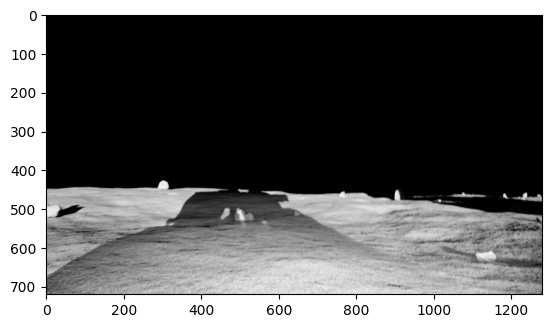

In [12]:
# Display a sample image as a sanity check
from IPython.display import Image
front_left_path=IMAGE_FILE_NAMES["front_left"]
file_name_base = os.listdir(front_left_path)[0]
file_name = os.path.join(front_left_path, file_name_base)
show_img(file_name)
# Image(filename=file_name)

## Depth-Anything from HuggingFace


In [13]:
# Run Depth Anything on a single image to evaluate
# !pip install --upgrade --force-reinstall Pillow
# from PIL import Image
def generate_depth_map_for_single_image(filepath: str) -> None:
    """
    Generates and displays a depth map for a single image.

    Args:
        filepath (str): Path to the image file.

    Returns:
        None: Displays the original image and depth map.
    """
    # Load the depth estimation pipeline
    pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-base-hf")

    # Load the image
    # image = Image.open(filepath)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = convert_image_to_base64(filepath)

    # Generate the depth map
    depth_map = pipe(image)["depth"]

    # Display the original image and the depth map
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(depth_map, cmap="viridis")
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
    
generate_depth_map_for_single_image(file_name)

Device set to use mps:0


NotImplementedError: The operator 'aten::upsample_bicubic2d.out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [14]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

device = "cuda" if torch.cuda.is_available() else "cpu"
# checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
checkpoint = "LiheYoung/depth-anything-small-hf"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint).to(device)


pipe = pipeline("depth-estimation", model=checkpoint, device=device)

Device set to use cpu


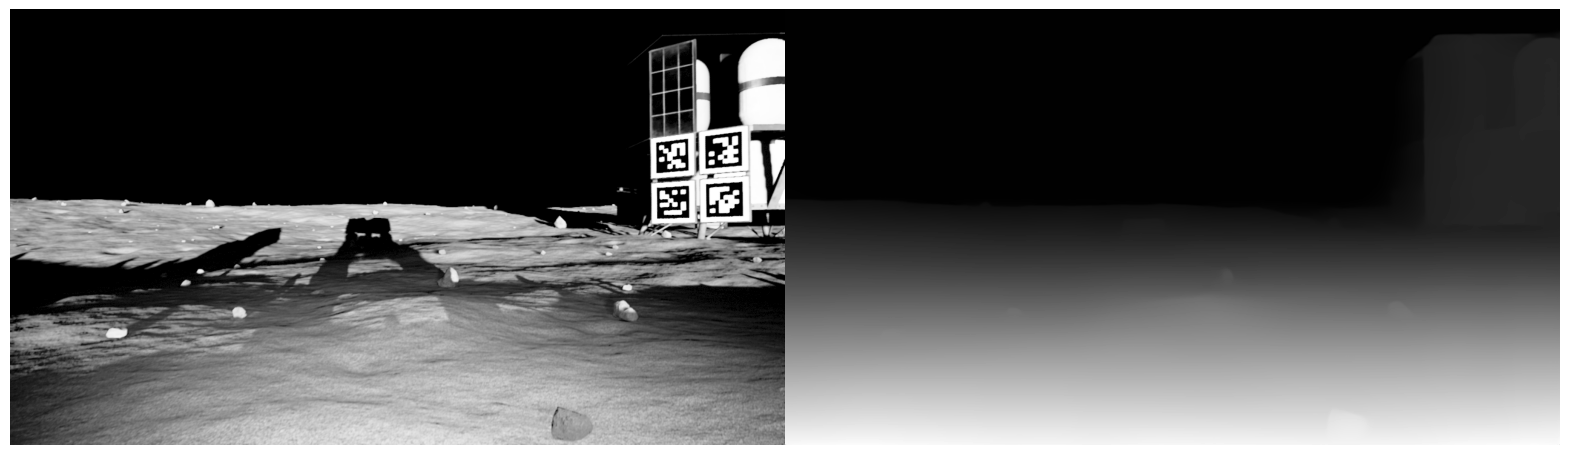

In [26]:
# i = 1800
i = 37

image_path = os.path.expanduser(
    # "~/LunarAutonomyChallenge/output/example_trajectory_images_clipped/{}.png".format(i)
    "~/Documents/Projects/Stanford/lunar_autonomy_challenge/data_collection_1/front_left/{}.png".format(i)
)
image_to_plot = cv2.imread(image_path)
image_to_plot = cv2.cvtColor(image_to_plot, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image = convert_image_to_base64(image_path)

predictions = pipe(image)

# Plot image and predicted depth side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"wspace": 0, "hspace": 0})
axes[0].imshow(image_to_plot, cmap="gray")
axes[1].imshow(predictions["depth"], cmap="gray")
for ax in axes:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Apple Depth Pro


In [27]:
import depth_pro

ImportError: No module named 'timm.layers'


In [28]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()
model.eval()

# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

RuntimeError: Unknown model (vit_large_patch14_dinov2)

## Stereo

- Stereo baseline = 0.162 m
- All cameras FOV = 1.22 radians (70 degrees)


In [29]:
W, H = 1280, 720
FOV = 1.22  # radians
BASELINE = 0.162  # meters
FOCAL_LENGTH = (W / 2) / np.tan(FOV / 2)

# data_path = Path("../../output/data_collection")
data_path = data_dir

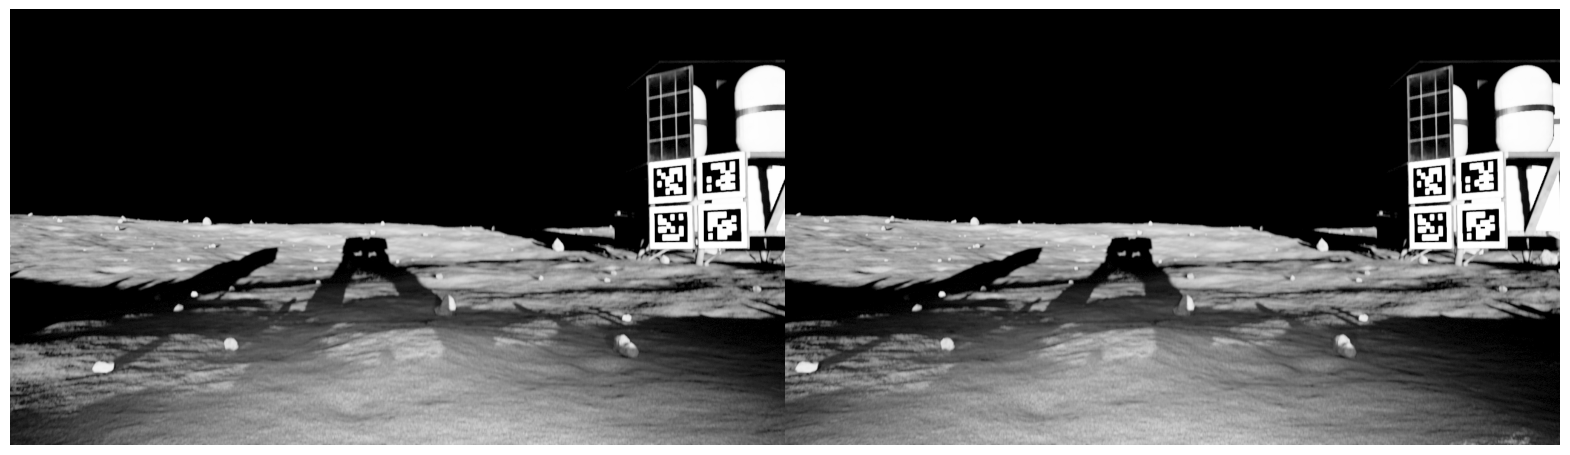

In [30]:
i = 40

left_image_path = os.path.join(data_path, "front_left", f"{i}.png")
right_image_path = os.path.join(data_path, "front_right", f"{i}.png")
# left_image = Image.open(left_image_path)
# right_image = Image.open(right_image_path)
left_image = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)

# Plot image and predicted depth side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"wspace": 0, "hspace": 0})
axes[0].imshow(left_image, cmap="gray")
axes[1].imshow(right_image, cmap="gray")
for ax in axes:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

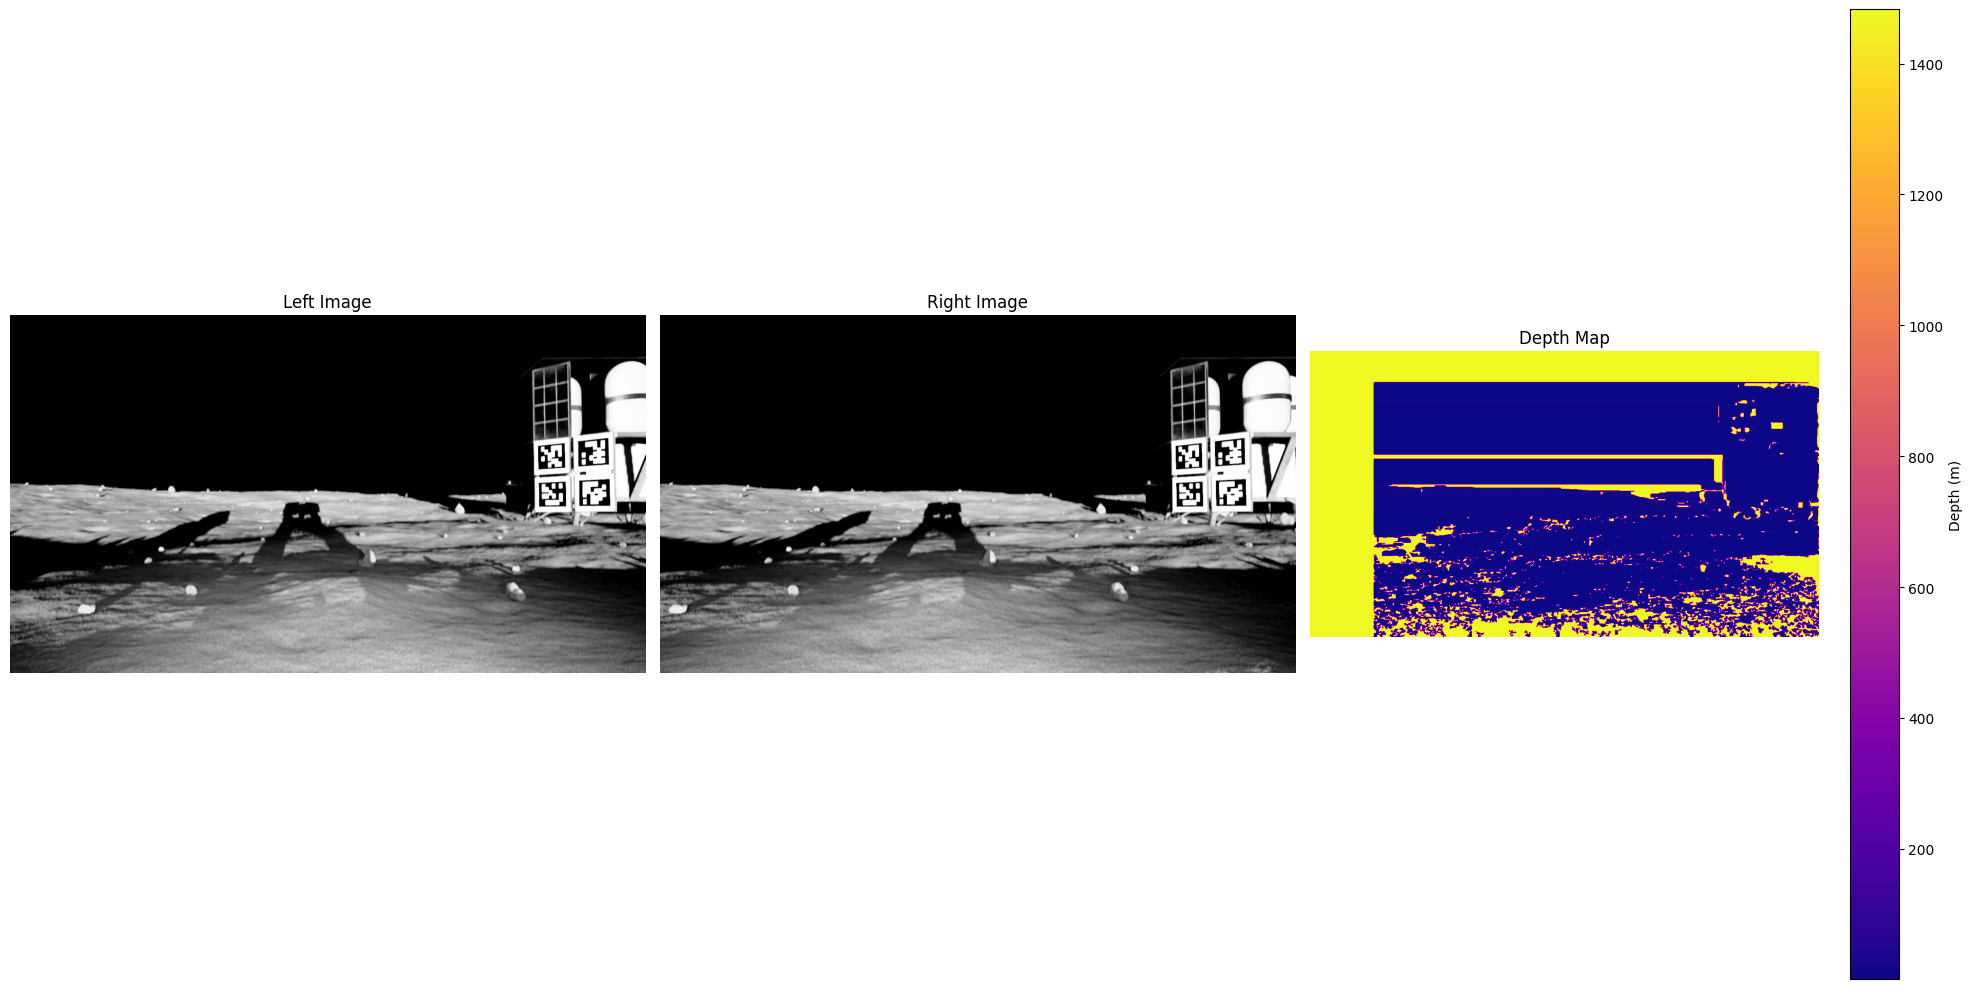

In [31]:
# Stereo BM or SGBM for disparity computation
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16 * 10,
    blockSize=9,
    P1=8 * 3 * 3**2,  # Penalty for small changes in disparity
    P2=32 * 3 * 3**2,  # Penalty for larger changes in disparity
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
)

# Compute disparity map
left_image = np.array(left_image)
right_image = np.array(right_image)
disparity_map = stereo.compute(left_image, right_image).astype(np.float32) / 16.0

# Convert disparity to depth
# Avoid division by zero by setting a minimum disparity value
disparity_map[disparity_map <= 0] = 0.1  # Prevent zero division
depth_map = (FOCAL_LENGTH * BASELINE) / disparity_map

# Plot the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title("Left Image")
plt.imshow(left_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Right Image")
plt.imshow(right_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Depth Map")
plt.imshow(depth_map, cmap="plasma")
plt.colorbar(label="Depth (m)")
plt.axis("off")

plt.tight_layout()
plt.show()

### OpenCV


In [ ]:
from lac.perception.depth import compute_stereo_depth

In [32]:
def compute_stereo_depth(
    img_left: np.ndarray,
    img_right: np.ndarray,
    baseline: float,
    focal_length_y: float,
    semi_global: bool = False,
):
    """
    img_left: np.ndarray (H, W) - Grayscale left image
    img_right: np.ndarray (H, W) - Grayscale right image
    baseline: float - Stereo baseline in meters
    focal_length_y: float - Horizontal focal length in pixels
    """
    # Create a StereoBM object (you can also use StereoSGBM for better results)
    min_disparity = 0
    num_disparities = 64  # Should be divisible by 16
    block_size = 15

    if semi_global:
        stereo = cv2.StereoSGBM_create(
            minDisparity=min_disparity,
            numDisparities=num_disparities,
            blockSize=block_size,
            P1=8 * 3 * block_size**2,
            P2=32 * 3 * block_size**2,
            disp12MaxDiff=1,
            uniquenessRatio=10,
            speckleWindowSize=100,
            speckleRange=32,
        )
    else:
        stereo = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)

    # Compute the disparity map
    disparity = stereo.compute(img_left, img_right)

    # Normalize the disparity for visualization
    disparity_normalized = cv2.normalize(
        disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX
    )
    disparity_normalized = np.uint8(disparity_normalized)

    # Convert disparity to depth (requires camera calibration parameters)
    # Assuming known focal length (f) and baseline (b) of the stereo setup
    disparity[disparity == 0] = 0.1  # Avoid division by zero
    depth = (focal_length_y * baseline) / disparity

    return disparity, depth

In [33]:
focal_length_y = H / (2 * np.tan(FOV / 2))

disparity, depth = compute_stereo_depth(
    np.array(left_image), np.array(right_image), BASELINE, focal_length_y, semi_global=False
)

/var/folders/mk/2gj1khx94wlfpyn39bq4mwbr0000gn/T/ipykernel_15100/220398586.py:46: RuntimeWarning: divide by zero encountered in divide
  depth = (focal_length_y * baseline) / disparity


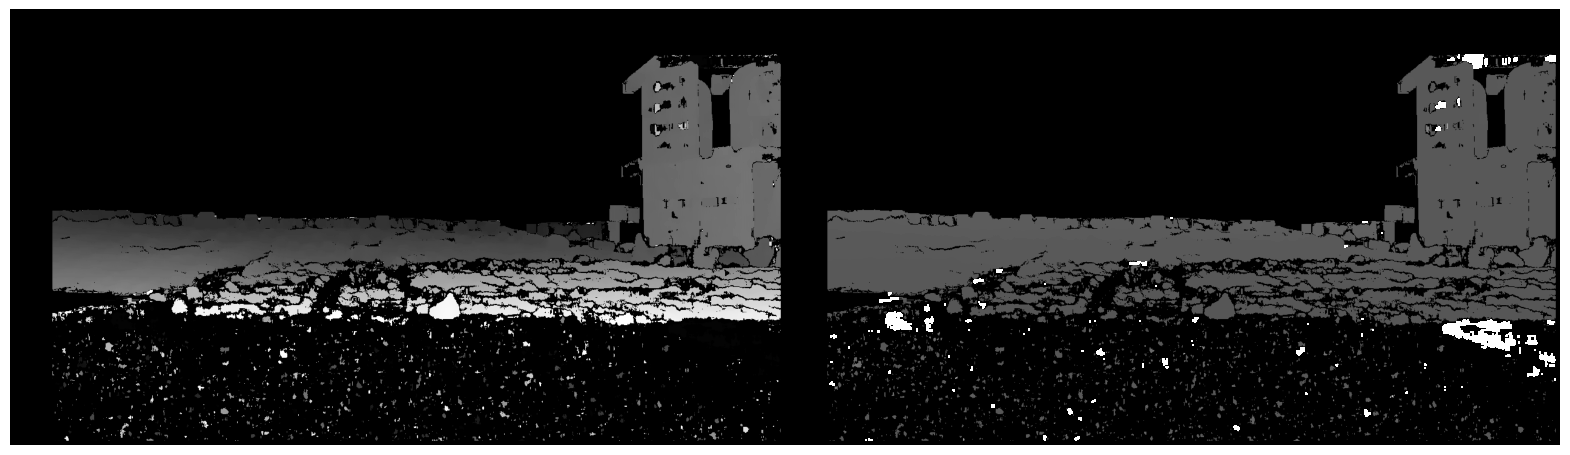

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"wspace": 0, "hspace": 0})
axes[0].imshow(disparity, cmap="gray")
axes[1].imshow(depth, cmap="gray")
for ax in axes:
    ax.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Intel DPT


In [35]:
# Directory paths
input_dir = IMAGE_FILE_NAMES["front_left"] 
output_dir = os.path.join(os.getcwd(), "depth_maps")

os.makedirs(output_dir, exist_ok=True)

In [36]:
# Load the model and processor
model_name = "Intel/dpt-large"
processor = DPTImageProcessor.from_pretrained(model_name)
model = DPTForDepthEstimation.from_pretrained(model_name)

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
model.eval()

DPTForDepthEstimation(
  (dpt): DPTModel(
    (embeddings): DPTViTEmbeddings(
      (patch_embeddings): DPTViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DPTViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x DPTViTLayer(
          (attention): DPTViTAttention(
            (attention): DPTViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DPTViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DPTViTIntermediate(
            

In [43]:
# Singular Image
i = 37

output_dir = os.path.join(os.getcwd(), "depth_maps")

input_path = os.path.join(data_path, "front_left", f"{i}.png")

# Load image
image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

# Convert grayscale to 3-channel image (required for some models)
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Prepare image for the model
inputs = processor(images=image_rgb, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=(image.shape[0], image.shape[1]),  # Use OpenCV image shape
    mode="bicubic",
    align_corners=False,
)

# Convert depth prediction to a format suitable for saving
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

# Save depth map
cv2.imwrite(os.path.join(output_dir, "test_dpt_1.png"), formatted)

# except Exception as e:
#     print(f"Failed to process {input_path}: {e}")

True

In [ ]:
# Multiple Images in a directory

output_dir = os.path.join(os.getcwd(), "depth_maps")

# Loop through all images in the input directory
for image_file in tqdm(os.listdir(input_dir)):
    input_path = os.path.join(input_dir, image_file)
    output_path = os.path.join(output_dir, f"depth_{image_file}")

    try:
        # Load image using OpenCV
        image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)

        # Convert grayscale to 3-channel RGB (required for some models)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Prepare image for the model
        inputs = processor(images=image_rgb, return_tensors="pt")

        # Perform inference
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        # Interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=(image.shape[0], image.shape[1]),  # Use OpenCV image shape
            mode="bicubic",
            align_corners=False,
        )
        
        # Convert depth prediction to a format suitable for saving
        output = prediction.squeeze().cpu().numpy()
        formatted = (output * 255 / np.max(output)).astype("uint8")

        # Save depth map using OpenCV
        cv2.imwrite(output_path, formatted)

    except Exception as e:
        print(f"Failed to process {image_file}: {e}")

print(f"Depth maps saved in {output_dir}")

In [52]:
from transformers import DPTForDepthEstimation, DPTImageProcessor

class LunarDepthEstimator:
    def __init__(
        self,
        model_name: str = "Intel/dpt-large",
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        """
        Initialize the depth estimator with DPT model.
        
        Args:
            model_name: Name of the pre-trained DPT model to use
            device: Device to run inference on ('cuda' or 'cpu')
        """
        self.device = device
        self.image_processor = DPTImageProcessor.from_pretrained(model_name)
        self.model = DPTForDepthEstimation.from_pretrained(model_name).to(device)
        self.model.eval()

    def process_image(
        self,
        image_path: str,
        min_depth: float = 0.0,
        max_depth: float = 100.0
    ) -> Tuple[np.ndarray, np.ndarray]:
        # Load and preprocess image
        image = pil_img.open(image_path)
        original_size = image.size
        
        # Convert image to RGB mode to ensure 3 channels
        image = image.convert('RGB')
        
        # Prepare image for the model
        inputs = self.image_processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values.to(self.device)
        
        # Generate depth prediction
        with torch.no_grad():
            outputs = self.model(pixel_values)
            predicted_depth = outputs.predicted_depth
        
        # Process the depth map
        depth_map = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=original_size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        
        # Convert to numpy and normalize
        depth_map = depth_map.squeeze().cpu().numpy()
        depth_map = self._normalize_depth(depth_map, min_depth, max_depth)
        
        return np.array(image), depth_map

    def process_stereo_pair(
        self,
        left_image_path: str,
        right_image_path: str,
        min_depth: float = 0.0,
        max_depth: float = 100.0
    ) -> Dict[str, np.ndarray]:
        """
        Process a stereo pair of images and return depth maps for both.
        
        Args:
            left_image_path: Path to the left camera image
            right_image_path: Path to the right camera image
            min_depth: Minimum depth value for normalization
            max_depth: Maximum depth value for normalization
            
        Returns:
            Dictionary containing original images and depth maps
        """
        left_image, left_depth = self.process_image(
            left_image_path, min_depth, max_depth
        )
        right_image, right_depth = self.process_image(
            right_image_path, min_depth, max_depth
        )
        
        return {
            'left_image': left_image,
            'left_depth': left_depth,
            'right_image': right_image,
            'right_depth': right_depth
        }

    @staticmethod
    def _normalize_depth(
        depth_map: np.ndarray,
        min_depth: float,
        max_depth: float
    ) -> np.ndarray:
        """
        Normalize depth map to specified range.
        
        Args:
            depth_map: Input depth map
            min_depth: Minimum depth value
            max_depth: Maximum depth value
            
        Returns:
            Normalized depth map
        """
        depth_map = np.clip(depth_map, min_depth, max_depth)
        depth_map = (depth_map - min_depth) / (max_depth - min_depth)
        return depth_map

def process_sequence_dpt(
    data_dir: str,
    output_dir: str,
    start_idx: int = 0,
    end_idx: Optional[int] = None,
    step: int = 1
):
    """
    Process a sequence of stereo images from the lunar dataset.
    
    Args:
        data_dir: Directory containing the image sequences
        output_dir: Directory to save processed depth maps
        start_idx: Starting index for processing
        end_idx: Ending index for processing (None for all images)
        step: Step size for processing images
    """
    # Initialize depth estimator
    depth_estimator = LunarDepthEstimator()
    
    # Create output directories if they don't exist
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, "depth_maps"), exist_ok=True)
    
    # Process images
    image_files = sorted(os.listdir(os.path.join(data_dir, "front_left")))
    if end_idx is None:
        end_idx = len(image_files)
    
    for i in range(start_idx, end_idx, step):
        # Construct image paths
        left_image_path = os.path.join(data_dir, "front_left", f"{i}.png")
        right_image_path = os.path.join(data_dir, "front_right", f"{i}.png")
        
        # Process stereo pair
        results = depth_estimator.process_stereo_pair(
            left_image_path,
            right_image_path
        )
        
        # Save depth maps
        for camera in ['left', 'right']:
            depth_map = results[f'{camera}_depth']
            output_path = os.path.join(
                output_dir,
                "depth_maps",
                f"{camera}_{i}.npy"
            )
            np.save(output_path, depth_map)
        
        print(f"Processed frame {i}")

In [53]:
# Process first 10 frames
OUTPUT_DIR = os.path.join(os.getcwd(), "depth_maps")
process_sequence_dpt(
        data_dir=data_dir,
        output_dir=OUTPUT_DIR,
        start_idx=0,
        end_idx=10,
        step=1
    )

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processed frame 0
Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9


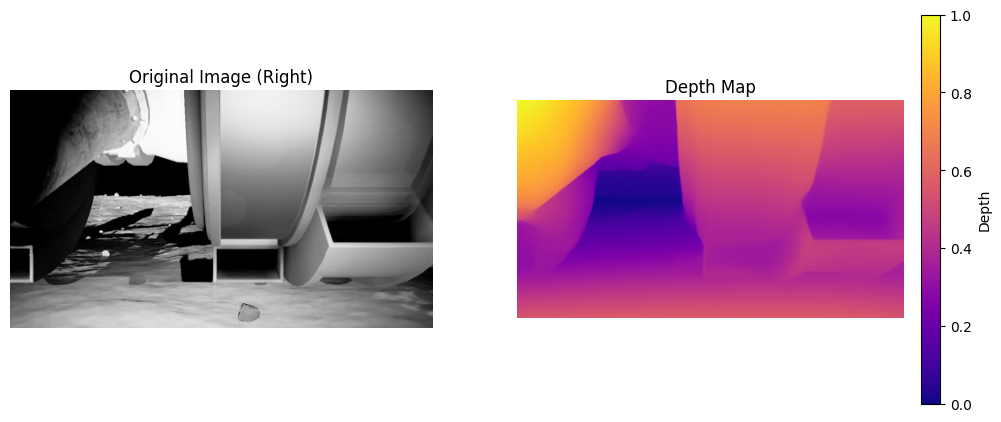

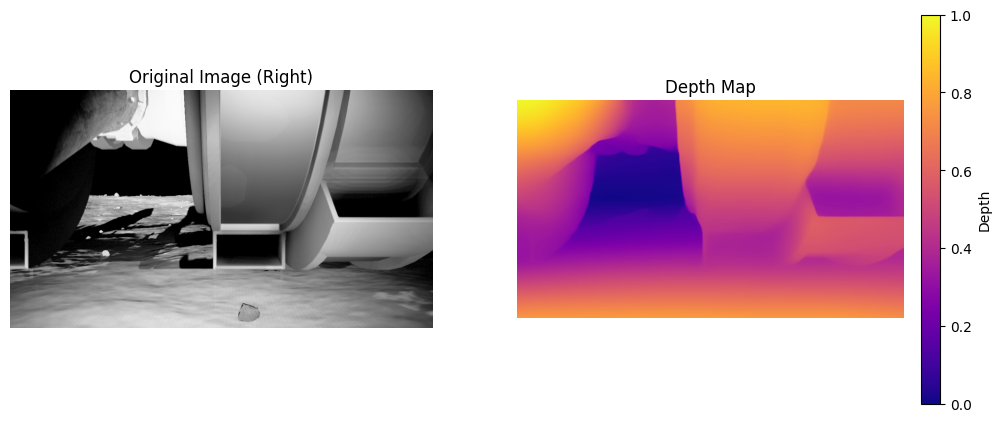

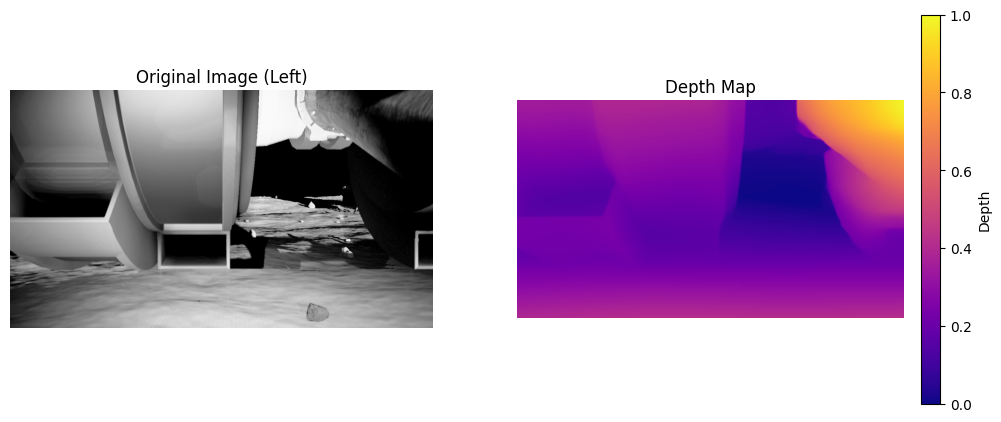

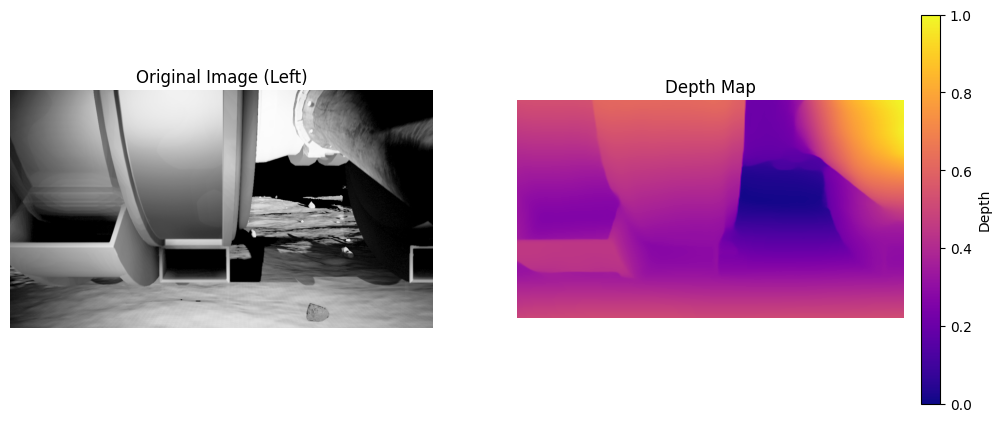

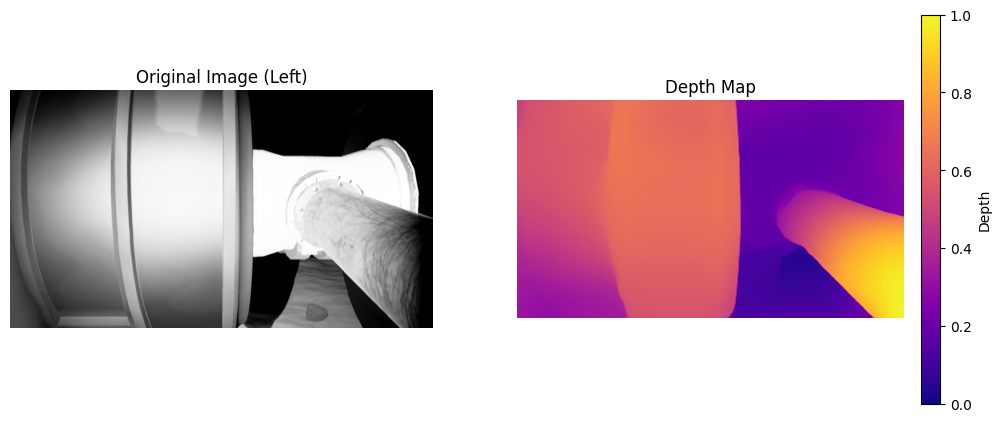

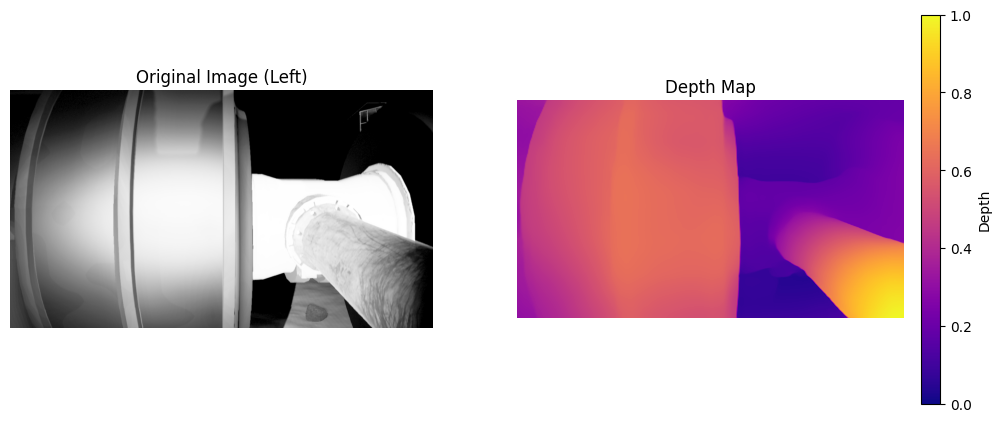

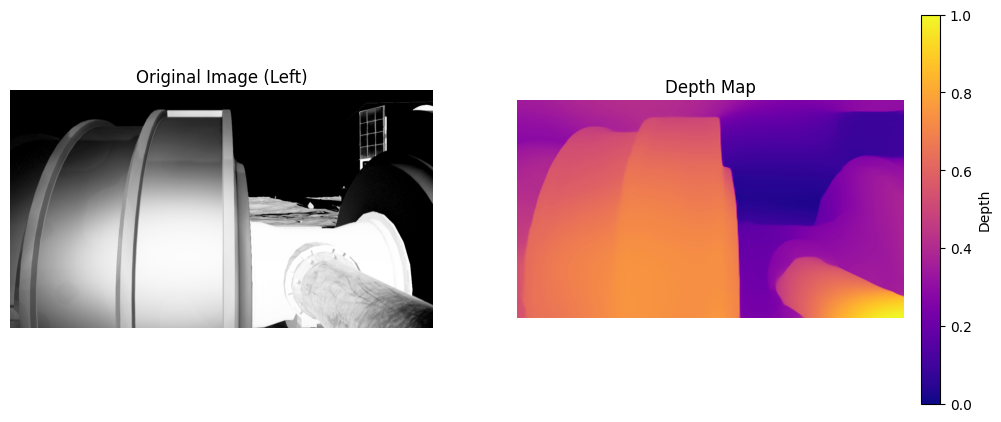

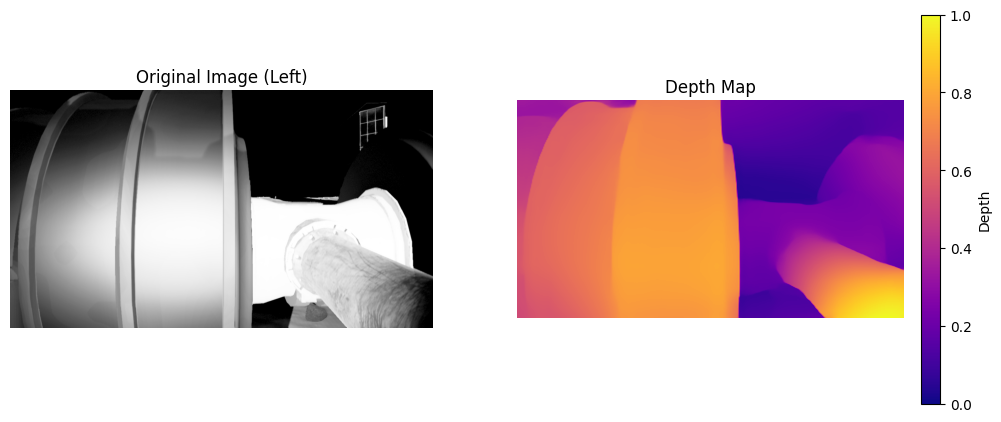

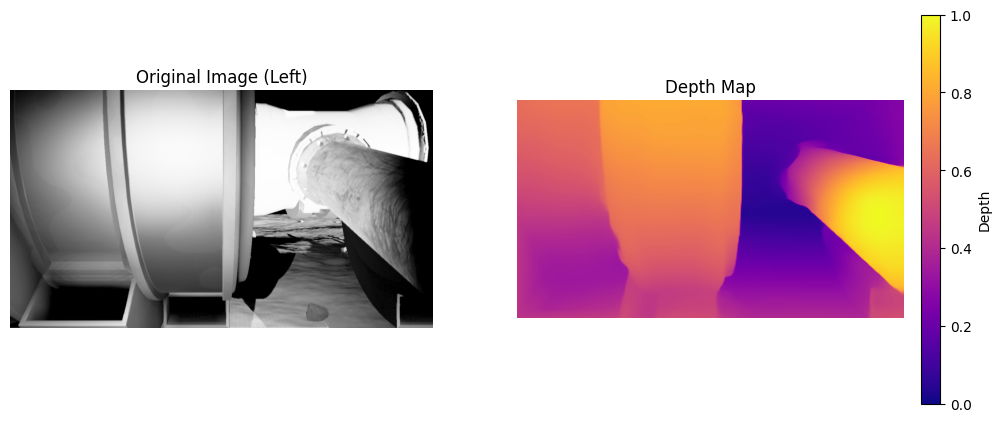

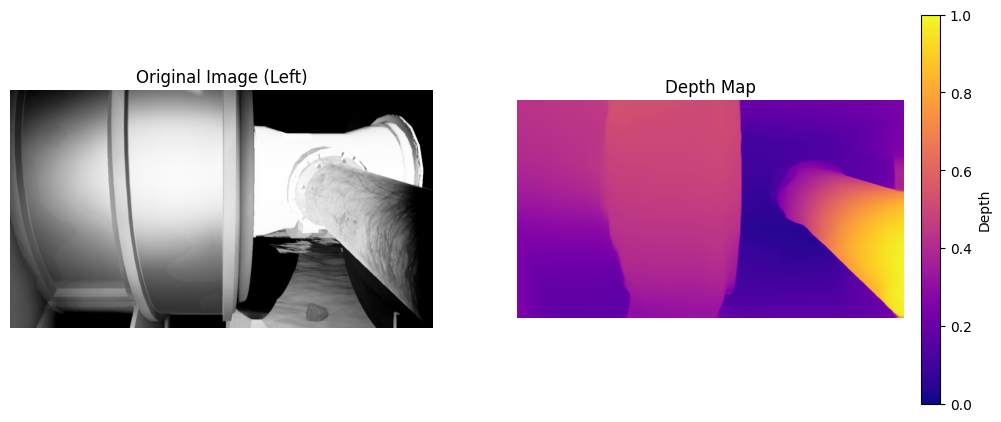

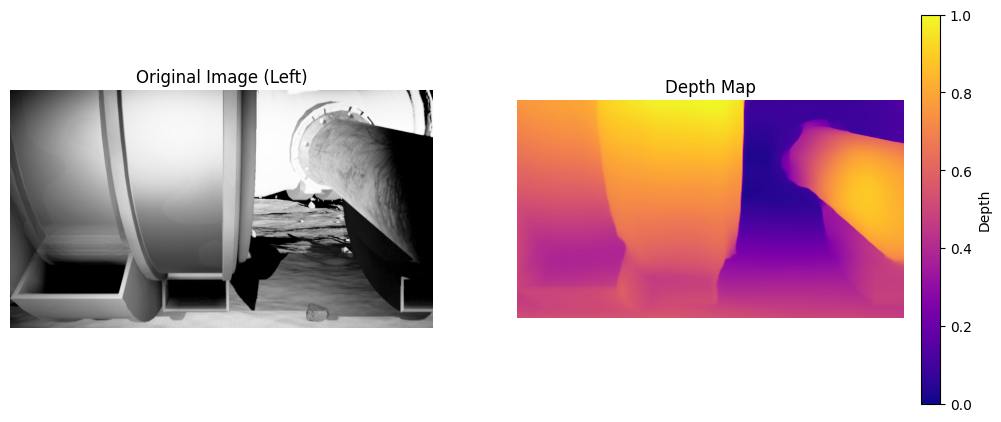

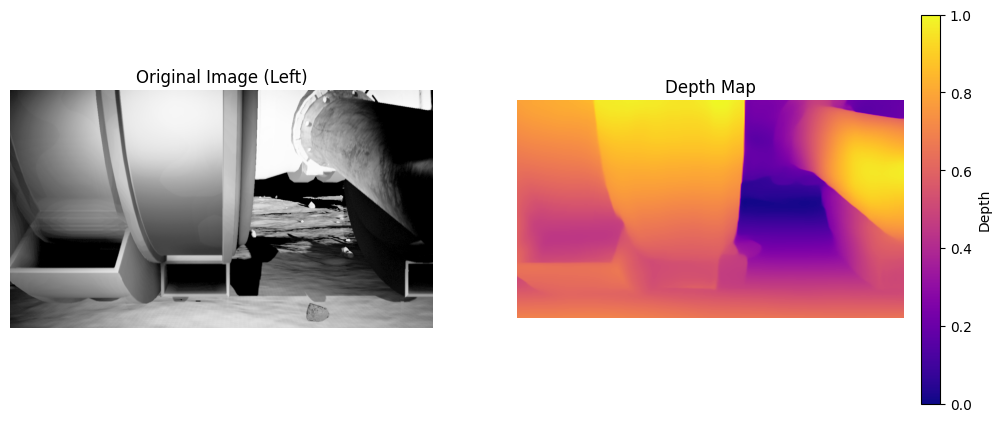

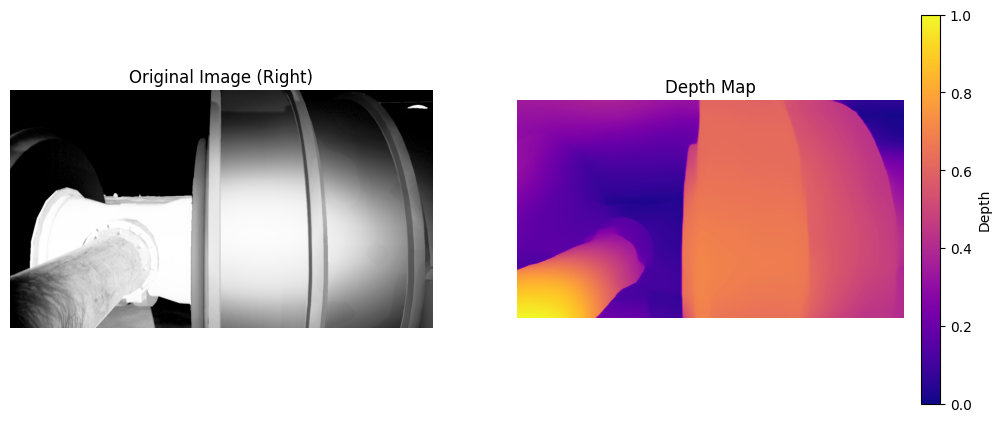

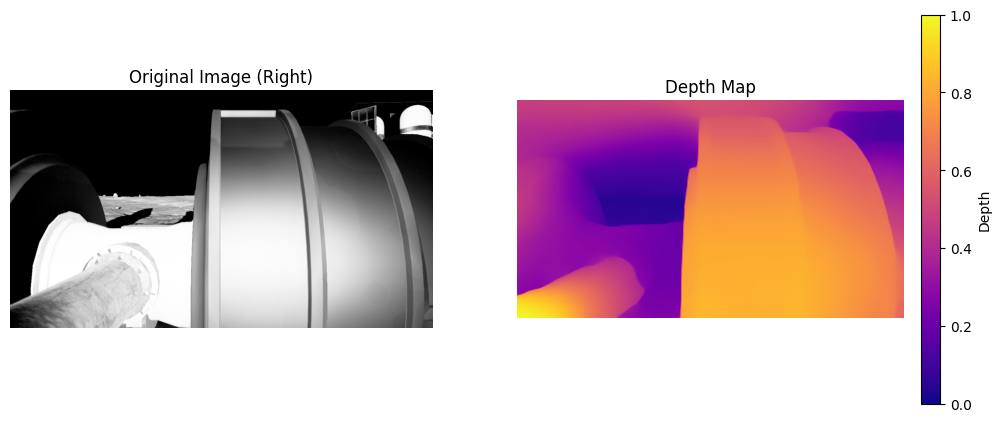

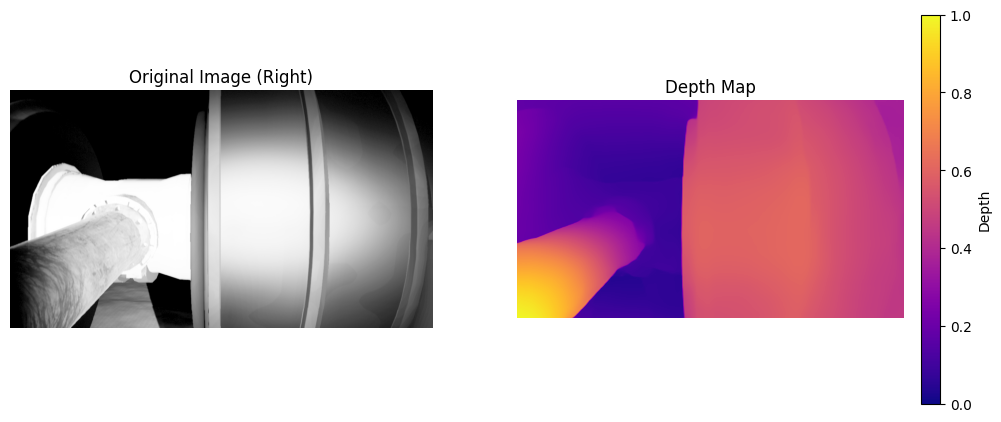

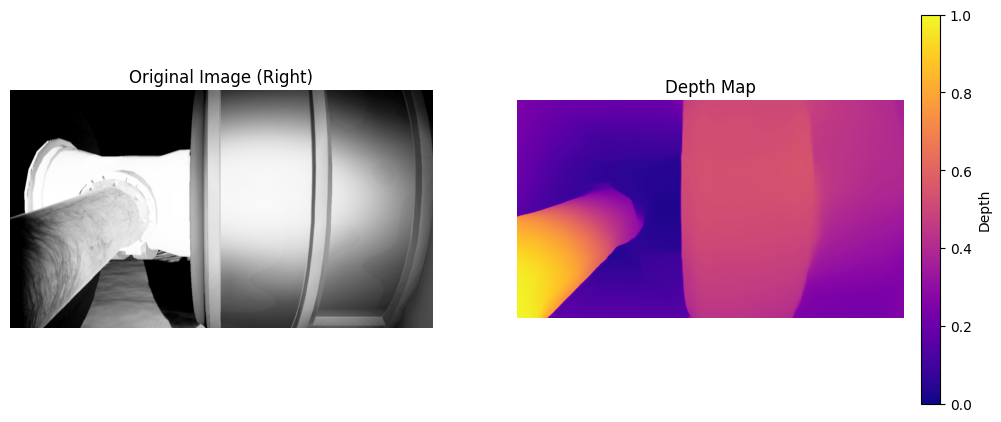

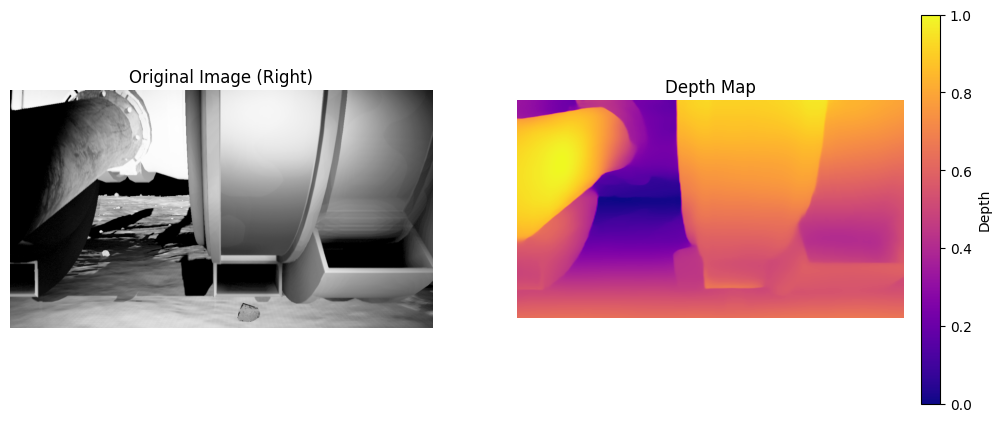

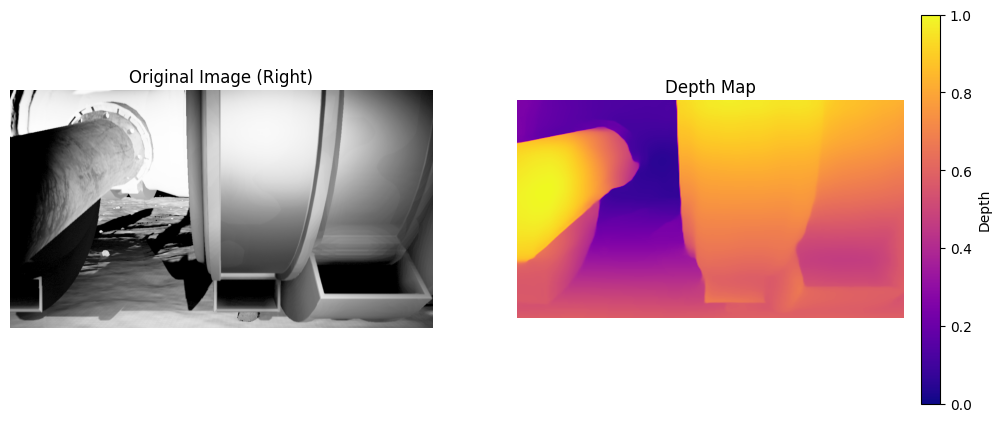

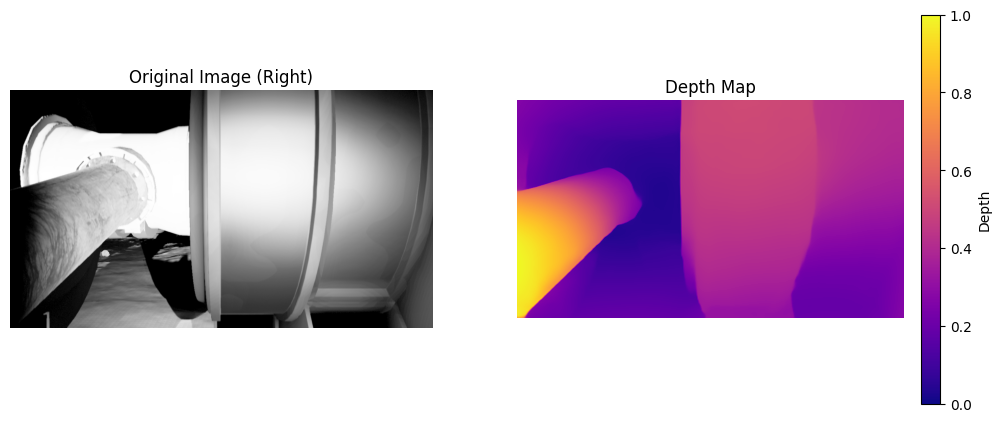

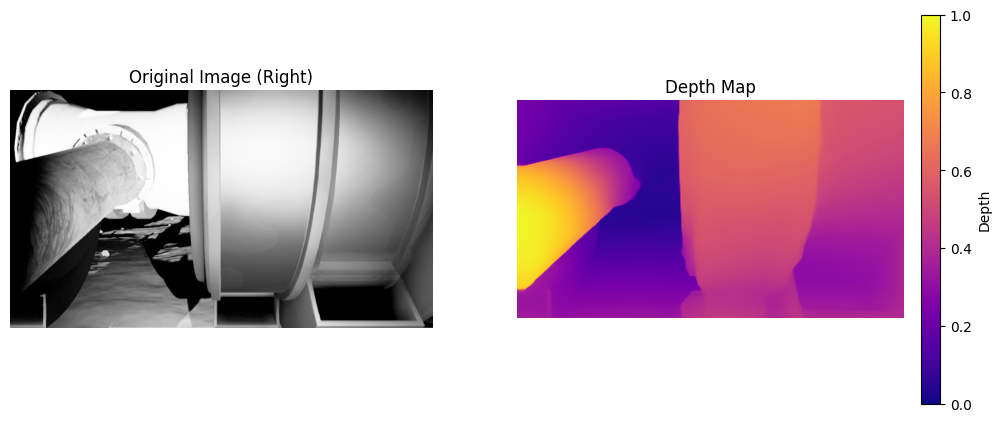

In [58]:
def visualize_depth_map_with_image(npy_file_path: str, data_dir: str, cmap: str = 'viridis'):
    """
    Visualize a depth map stored as a .npy file alongside its corresponding image.

    Args:
        npy_file_path (str): Path to the .npy file containing the depth map.
        data_dir (str): Root directory containing original images.
        cmap (str): Colormap to use for visualization (default is 'viridis').
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    import os

    # Load the depth map
    depth_map = np.load(npy_file_path)
    depth_map_normalized = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))

    # Extract the corresponding image path
    filename = os.path.basename(npy_file_path)  # Extract "left_0.npy" or "right_0.npy"
    camera, index = filename.split('_')[0], filename.split('_')[1].split('.')[0]  # Get "left" or "right" and index
    image_path = os.path.join(data_dir, f"front_{camera}", f"{index}.png")

    if not os.path.exists(image_path):
        print(f"Warning: Corresponding image {image_path} not found.")
        return

    # Load the corresponding image
    image = Image.open(image_path).convert("RGB")

    # Plot image and depth map side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image)
    axes[0].set_title(f"Original Image ({camera.capitalize()})")
    axes[0].axis("off")

    im = axes[1].imshow(depth_map_normalized, cmap=cmap)
    axes[1].set_title("Depth Map")
    axes[1].axis("off")

    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="Depth")

    plt.show()

# Visualize all depth maps with corresponding images
for filename in os.listdir(os.path.join(OUTPUT_DIR, "depth_maps")):
    full_file_path = os.path.join(OUTPUT_DIR, "depth_maps", filename)
    visualize_depth_map_with_image(full_file_path, data_dir, cmap="plasma")